In [45]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(patchwork))

library(ComplexHeatmap)
library(circlize)
library(ggplot2)
library(ggsci)


In [46]:
ImmuneType<-read.csv('SLP_Immunotype_Assignments.csv')
colnames(ImmuneType)<-c('ImmuneType','subject.subjectGuid')
ImmuneType$ImmuneType<-as.character(ImmuneType$ImmuneType)

In [47]:
meta_data=read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')
meta_data_subset<-meta_data%>% filter(sample.visitName %in% c('Flu Year 1 Day 0'))

In [48]:
meta_data_subset<-left_join(meta_data_subset,ImmuneType,)

Joining with `by = join_by(subject.subjectGuid)`


In [63]:
table(metadata_to_plot$ImmuneType,metadata_to_plot$cohort.cohortGuid,metadata_to_plot$subject.biologicalSex,metadata_to_plot$CMV.IgG.Serology.Result.Interpretation)

, ,  = Female,  = Negative

   
    BR1 BR2
  1   9   0
  2   1   1
  3   6   1
  4   1   7

, ,  = Male,  = Negative

   
    BR1 BR2
  1   1   1
  2   3   3
  3   6   0
  4   2   8

, ,  = Female,  = Positive

   
    BR1 BR2
  1   4   2
  2   4   6
  3   0   2
  4   1   6

, ,  = Male,  = Positive

   
    BR1 BR2
  1   0   0
  2   8   4
  3   1   0
  4   0   4


Warning message:
“The input is a data frame-like object, convert it to a matrix.”


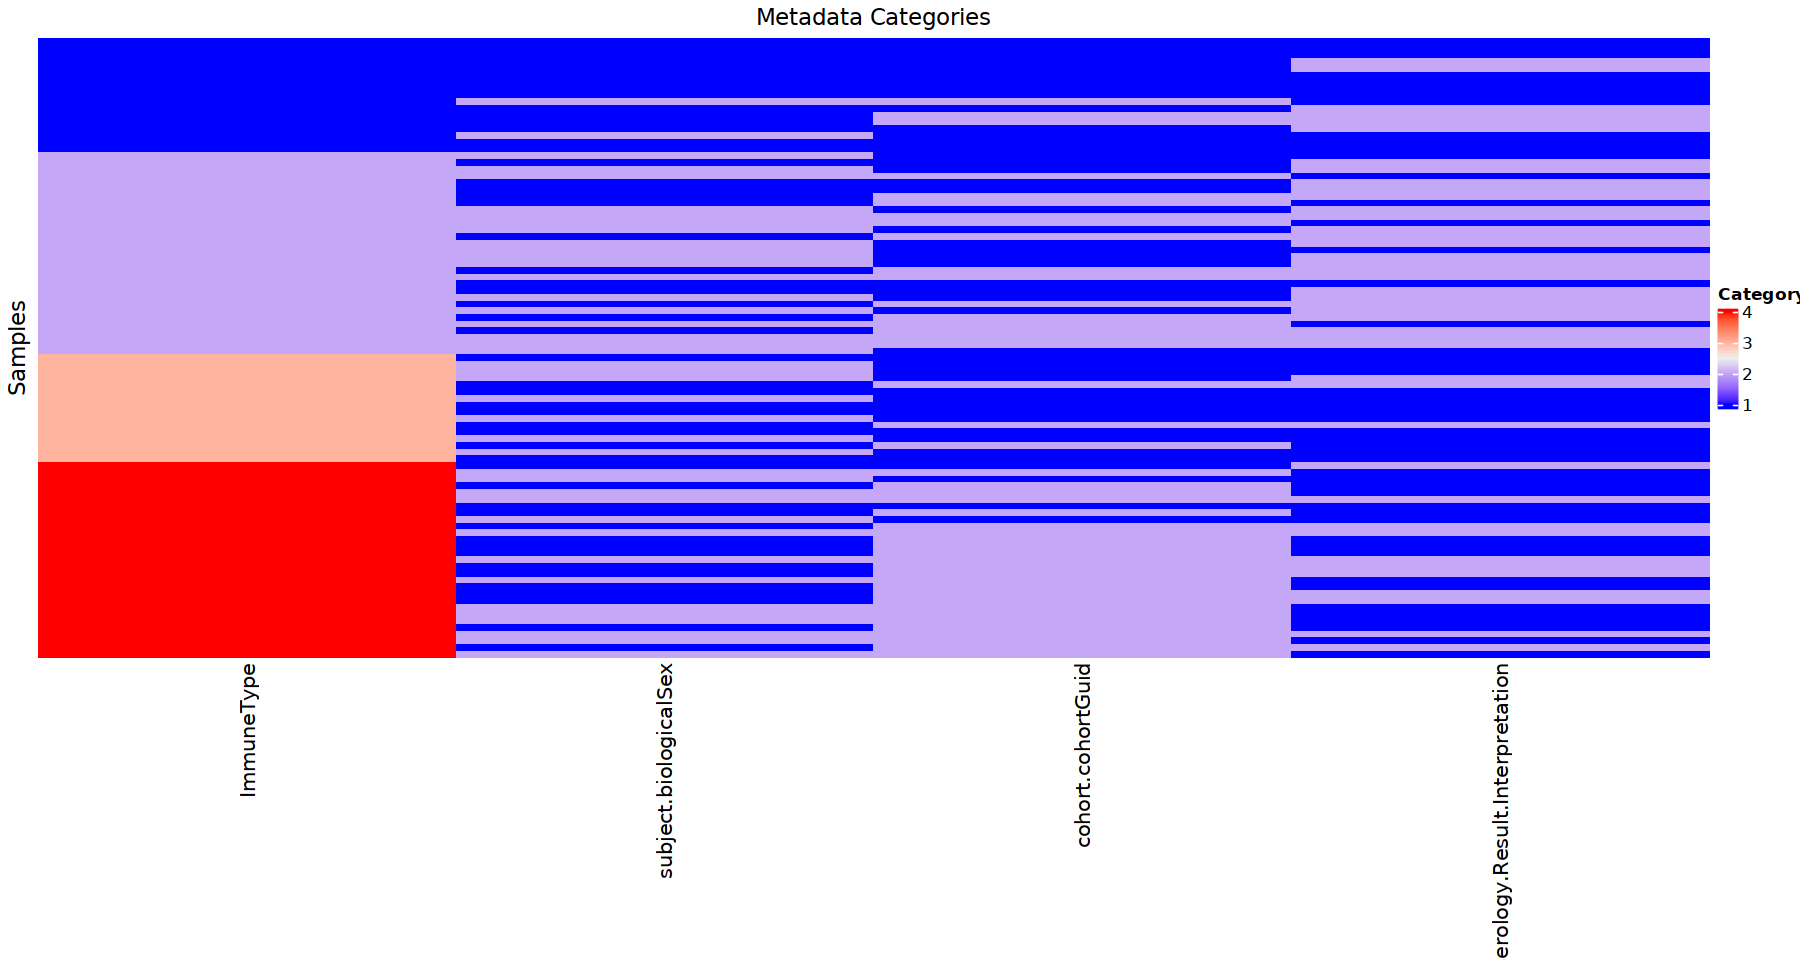

In [49]:
metadata_to_plot <- meta_data_subset[c('ImmuneType', 'subject.biologicalSex','cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation')]

metadata_matrix <- data.frame(lapply(metadata_to_plot, function(x) as.numeric(as.factor(x))))
metadata_matrix<-metadata_matrix %>% arrange(ImmuneType)
rownames(metadata_matrix) <- metadata_to_plot$subject.subjectGuid

total_categories <- sum(sapply(metadata_to_plot[, -4], function(x) length(unique(x))))

colors <- colorRampPalette(c("blue", "yellow", "red"))(total_categories)

Heatmap(metadata_matrix, name = "Category",
        cluster_rows = FALSE
        , cluster_columns = FALSE ,
        show_row_names = TRUE, show_column_names = TRUE,
        column_title = "Metadata Categories", row_title = "Samples")


In [50]:
file_list<-list.files(path = paste0("DESeq2_ImmuneType_only/"), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [51]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

In [52]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

In [53]:
freq <- DEG %>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated-ImmuneTypeX",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated-ImmuneTypeX",
                                                     TRUE ~ "Unchanged")) %>% filter(!Expression=='Unchanged')%>%
  group_by(celltype, Expression,ImmuneType) %>%
  summarise(count = n())
freq<-freq %>% mutate (count=case_when(Expression=="Down-regulated-ImmuneTypeX"~-count,TRUE~count))

`summarise()` has grouped output by 'celltype', 'Expression'. You can override
using the `.groups` argument.


In [54]:
orders<-freq
orders$count<-abs(orders$count)
orders<-orders%>%
  group_by(celltype) %>%
  summarize(value = sum(count))%>%arrange(desc(value)) %>% select (celltype) %>% pull()

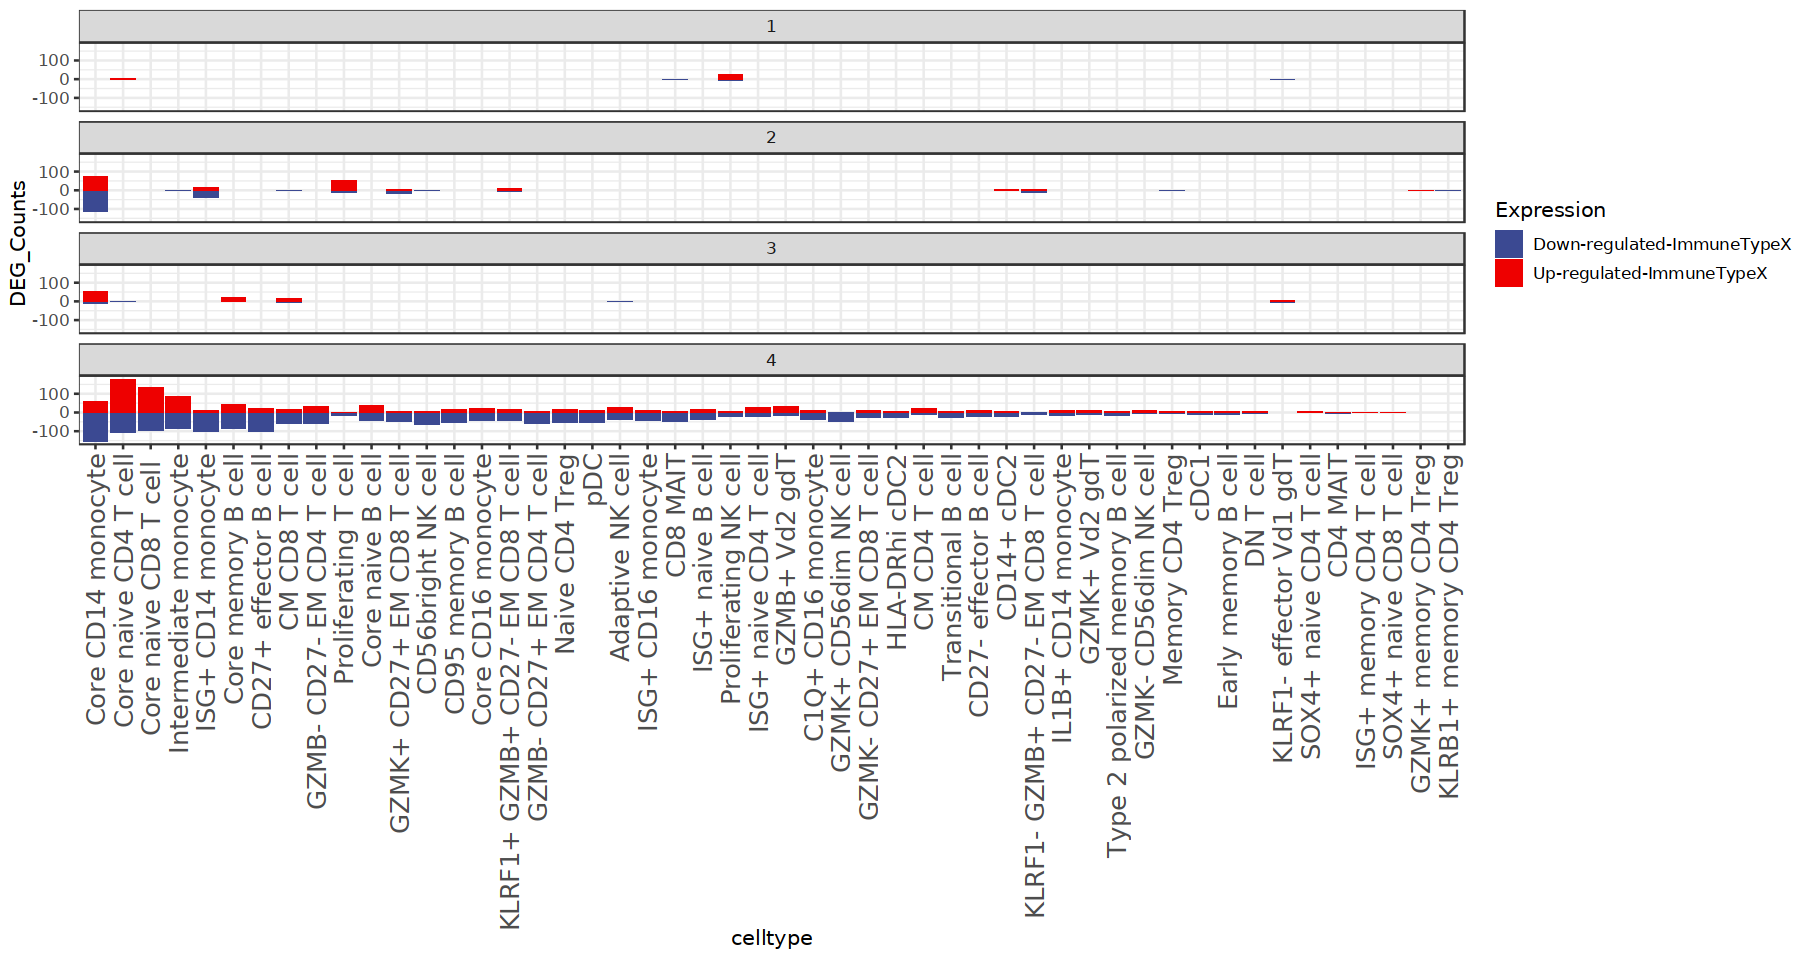

In [55]:
options(repr.plot.width = 15, repr.plot.height = 8)

freq$celltype<-factor(freq$celltype,levels=orders)
ggplot(freq, aes(x = celltype, y = count, fill = Expression)) +
  geom_bar(stat = "identity", position = "identity") +theme_bw(base_size=12)+  scale_fill_aaas()+
  labs(x = "celltype", y = "DEG_Counts") + facet_wrap(~ImmuneType,ncol=1)+ theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 15))

# Volcano

Adding missing grouping variables: `Expression`


Adding missing grouping variables: `Expression`
Warning message:
“Removed 6230 rows containing missing values (`geom_point()`).”


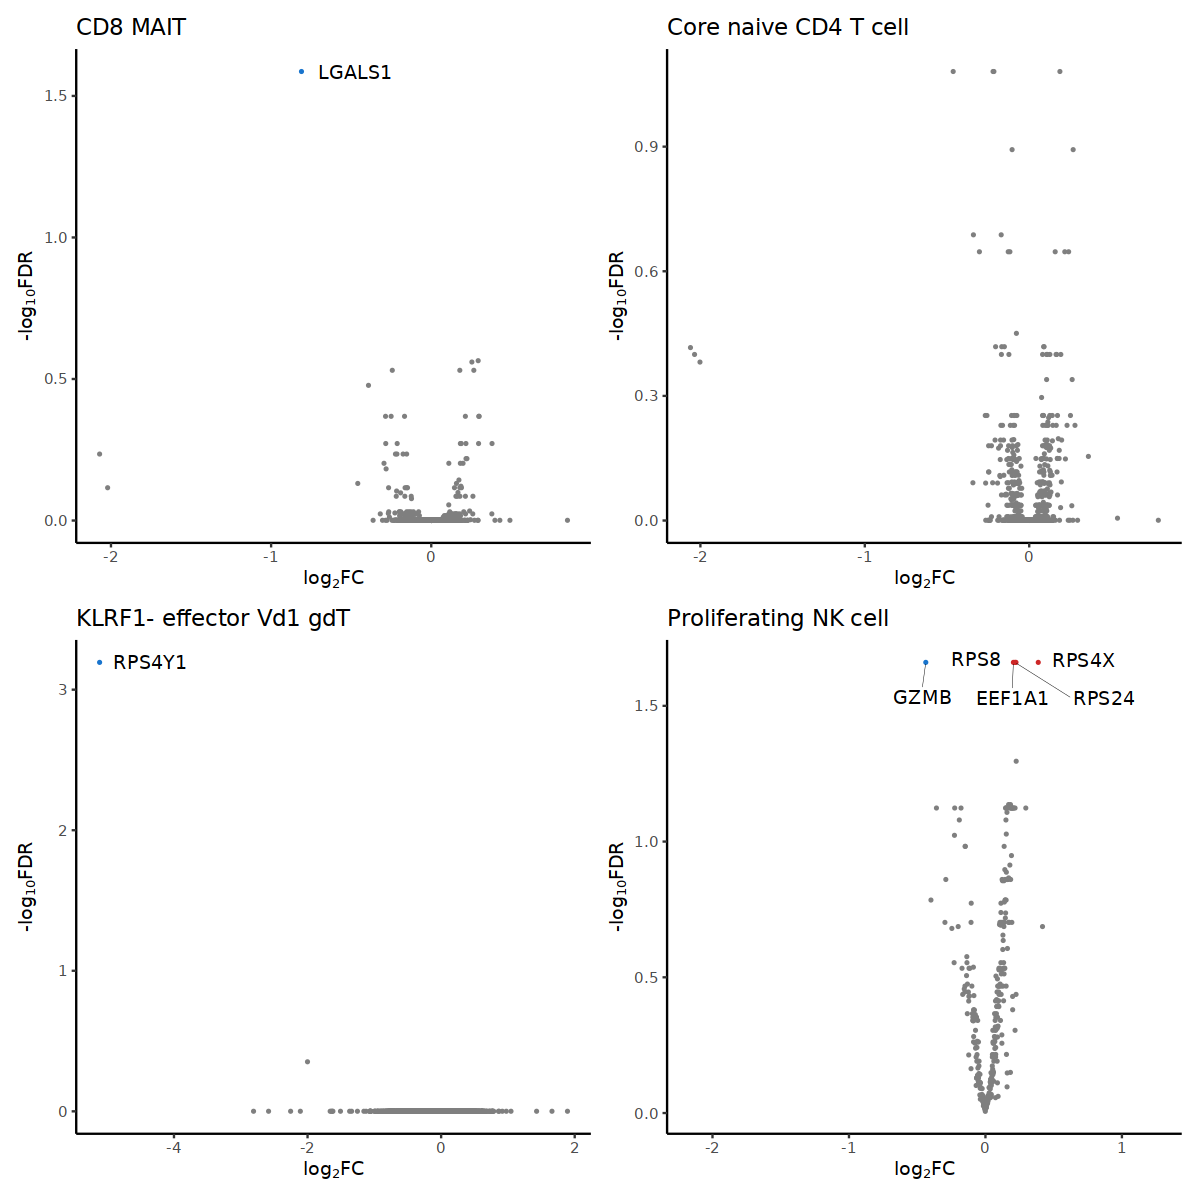

In [56]:
celltyppes_selected<-unique(freq%>% filter(ImmuneType==1) %>% select(celltype) %>% pull())
DEG_singleImmuneType<-DEG%>% filter(ImmuneType==1) %>% filter(celltype %in% celltyppes_selected)
Plot_list<-list()

for (i in 1:length(celltyppes_selected)){

data <- DEG_singleImmuneType %>% filter(celltype==celltyppes_selected[i])%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.05 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))
top <- 15
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top)
)
    
Plot_list[[i]]<-ggplot(data, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = Expression), size = 2/5) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated"="dodgerblue3", "Unchanged"="gray50", "Up-regulated"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=1.5))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=15,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(log2FoldChange, -log(padj,10), label = Gene),
                   size = 4)+ ggtitle(celltyppes_selected[i])+theme_classic()+ theme(legend.position = "none")
}
options(repr.plot.width = 10, repr.plot.height = 10)

wrap_plots(Plot_list)+ guides(colour = "colorbar",size = "none")

Adding missing grouping variables: `Expression`
Warning message:
“Removed 691 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3070 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4097 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 255 rows containing missing values (`geom_point()`).”
Warning message:
“ggrepel: 28 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 18 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


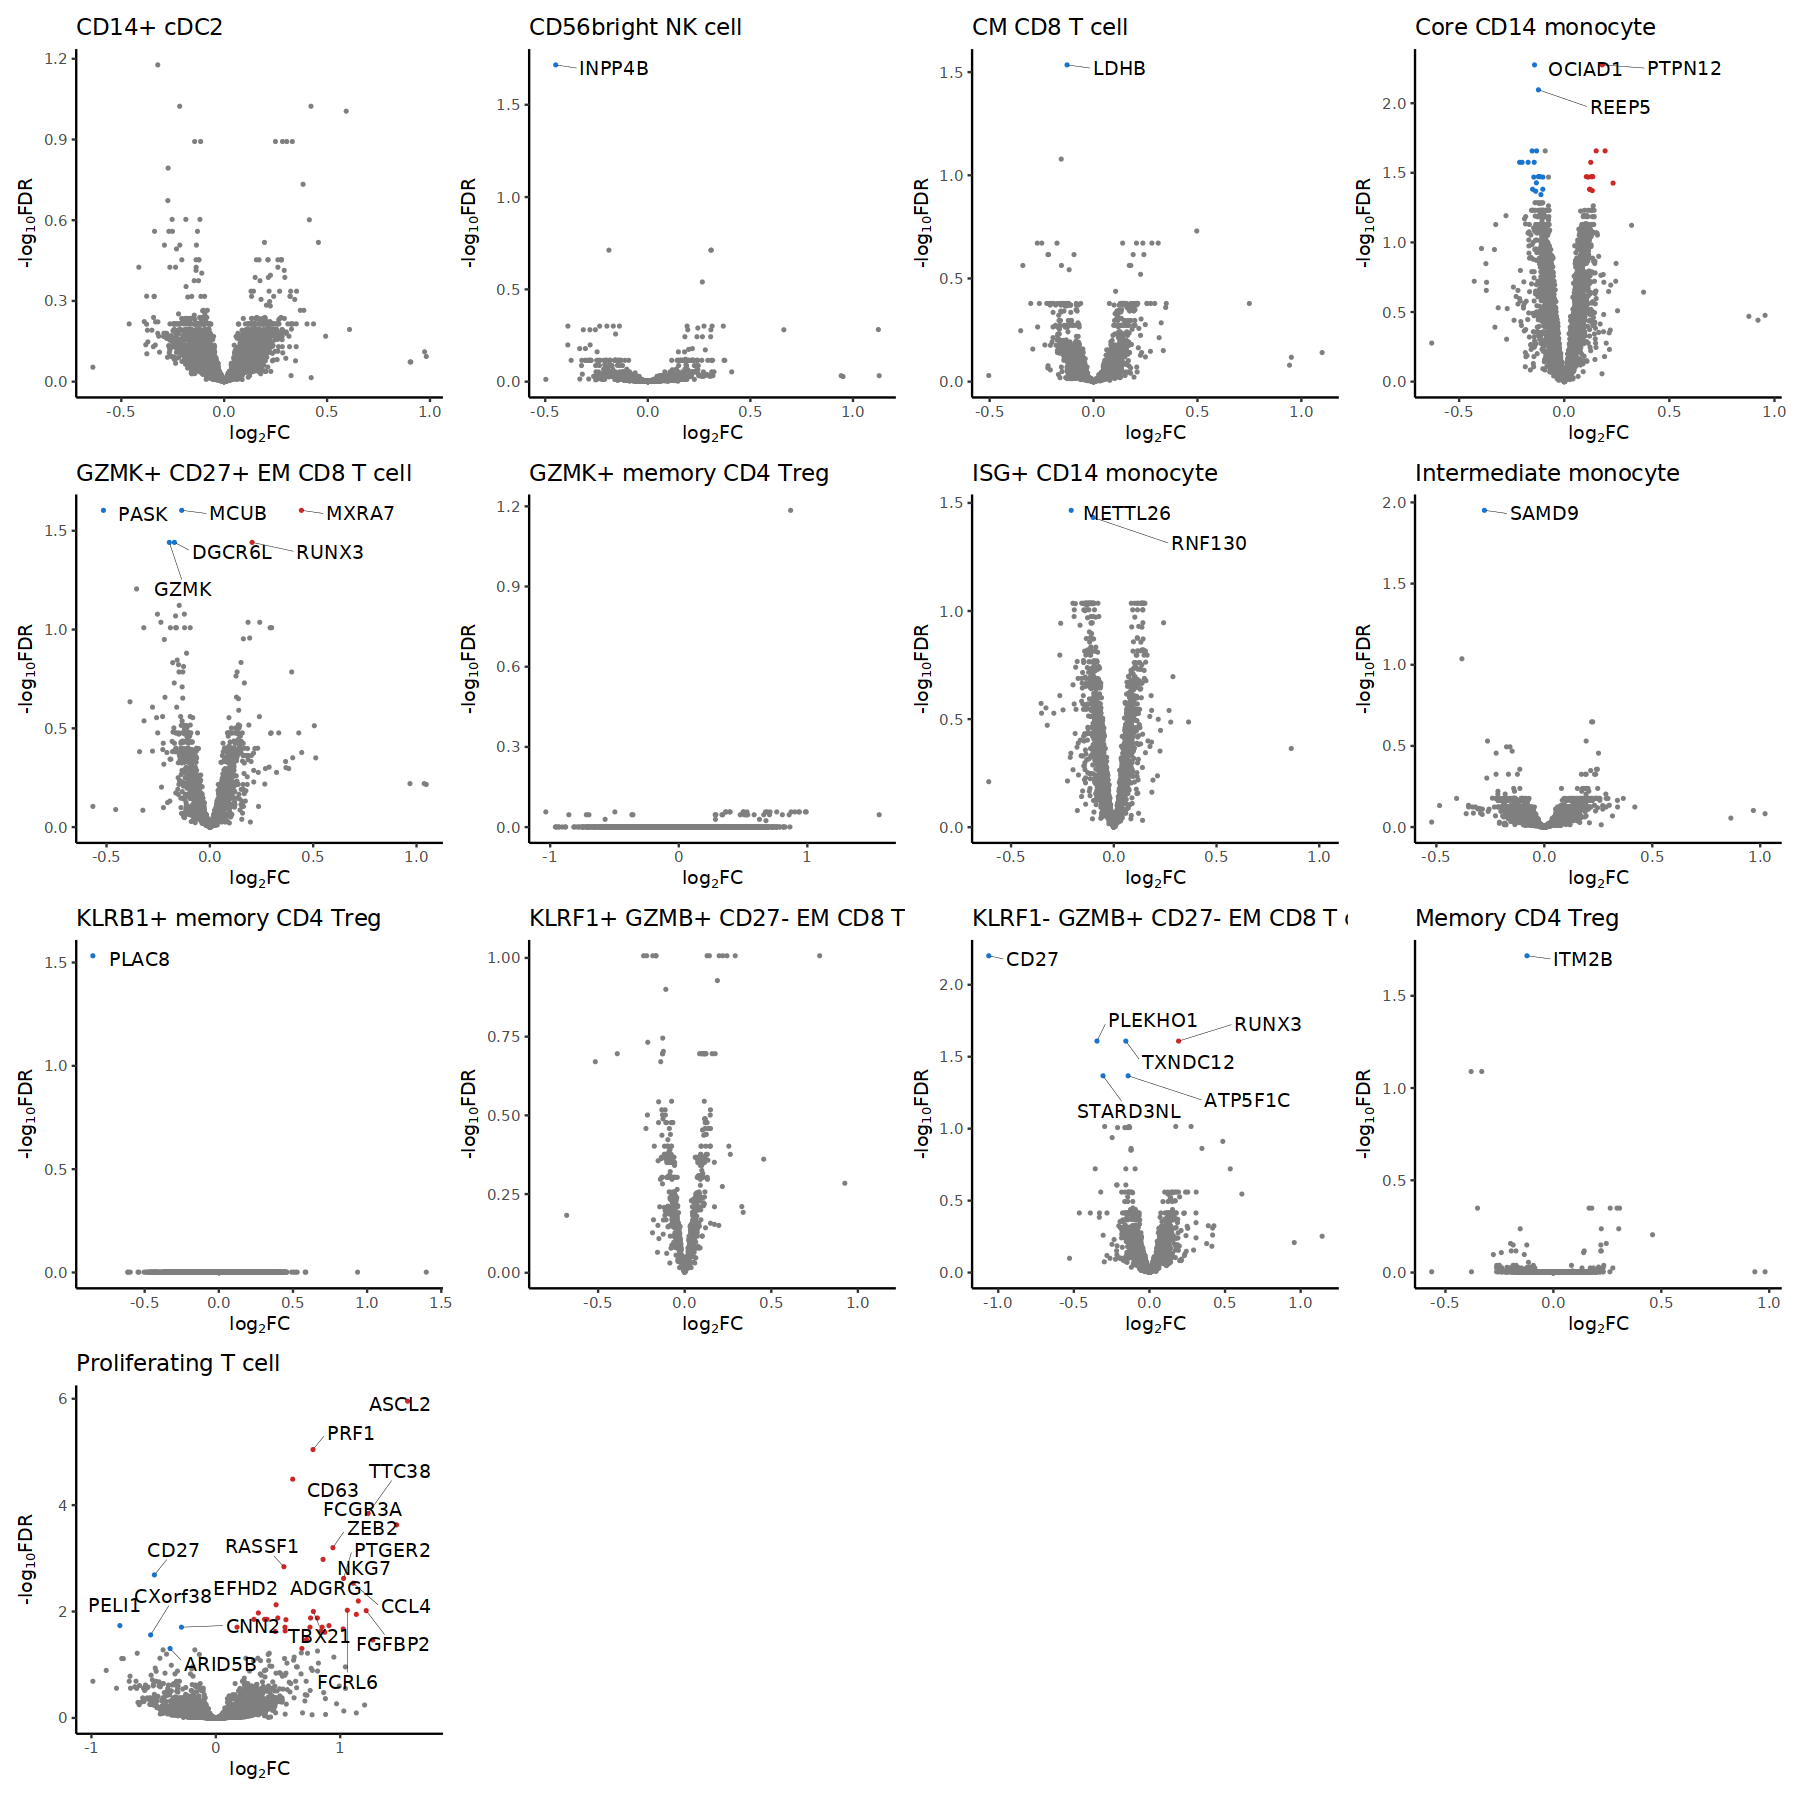

In [57]:
celltyppes_selected<-unique(freq%>% filter(ImmuneType==2) %>% select(celltype) %>% pull())
DEG_singleImmuneType<-DEG%>% filter(ImmuneType==2) %>% filter(celltype %in% celltyppes_selected)
Plot_list<-list()

for (i in 1:length(celltyppes_selected)){

data <- DEG_singleImmuneType %>% filter(celltype==celltyppes_selected[i])%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.05 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))
top <- 15
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top)
)
    
Plot_list[[i]]<-ggplot(data, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = Expression), size = 2/5) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated"="dodgerblue3", "Unchanged"="gray50", "Up-regulated"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=1.5))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=15,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(log2FoldChange, -log(padj,10), label = Gene),
                   size = 4)+ ggtitle(celltyppes_selected[i])+theme_classic()+ theme(legend.position = "none")
}
options(repr.plot.width = 15, repr.plot.height = 15)

wrap_plots(Plot_list)+ guides(colour = "colorbar",size = "none")

Adding missing grouping variables: `Expression`
Warning message:
“Removed 4205 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3455 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4260 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3971 rows containing missing values (`geom_point()`).”


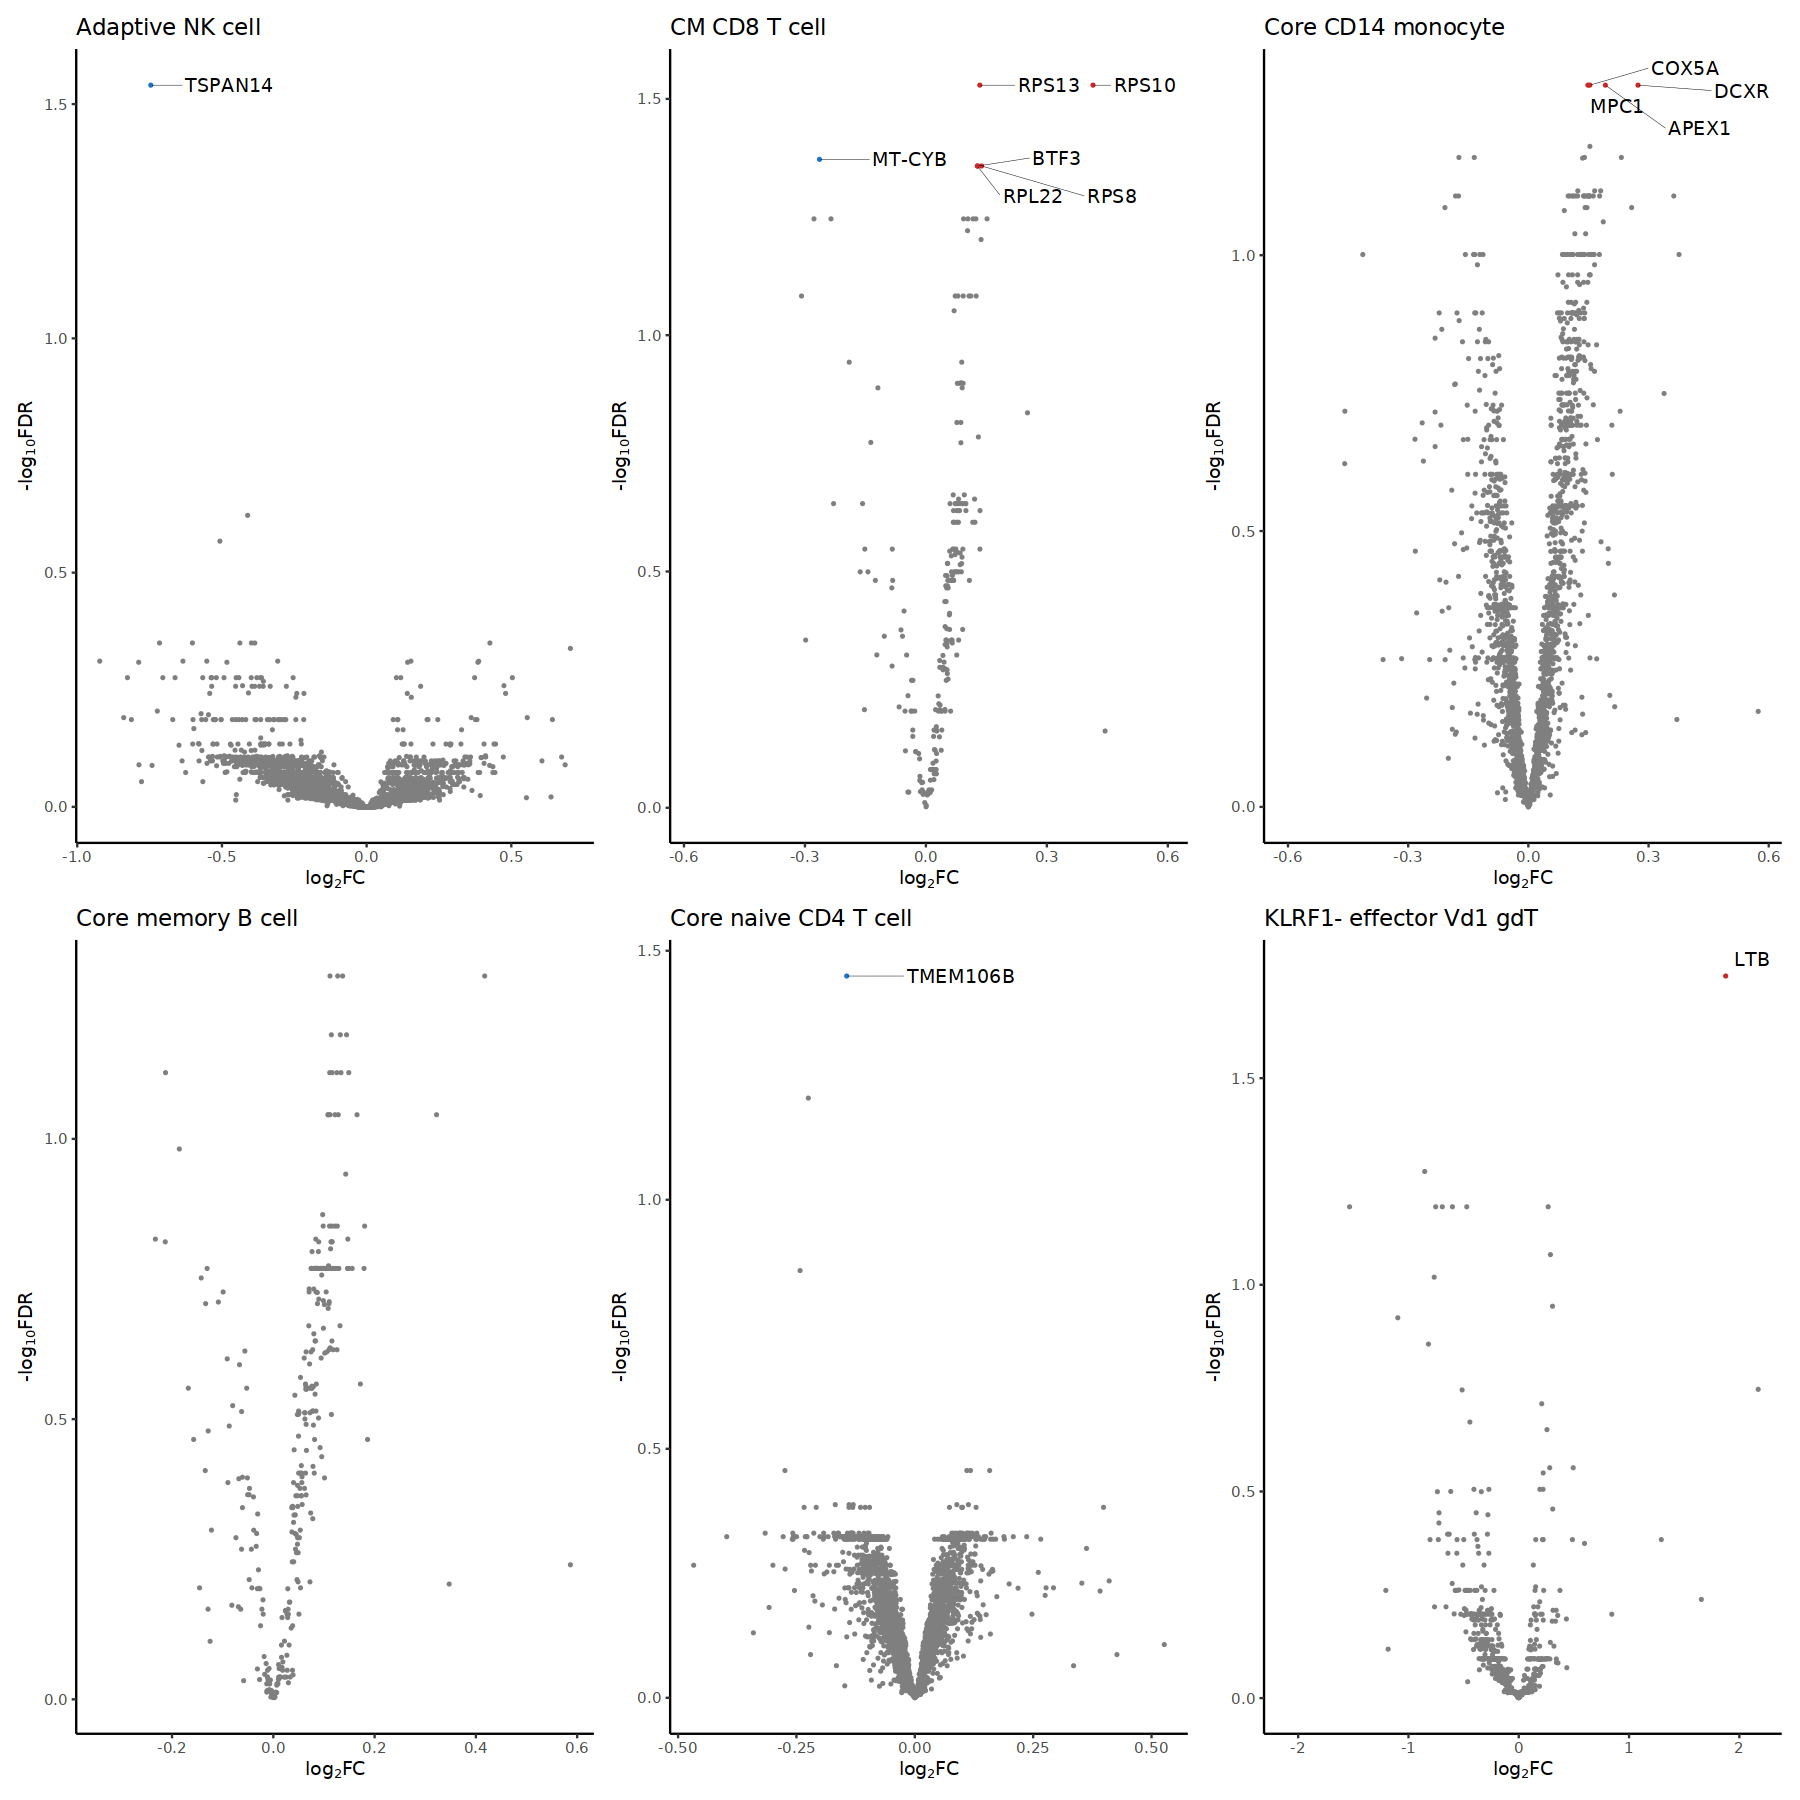

In [58]:
celltyppes_selected<-unique(freq%>% filter(ImmuneType==3) %>% select(celltype) %>% pull())
DEG_singleImmuneType<-DEG%>% filter(ImmuneType==3) %>% filter(celltype %in% celltyppes_selected)
Plot_list<-list()

for (i in 1:length(celltyppes_selected)){

data <- DEG_singleImmuneType %>% filter(celltype==celltyppes_selected[i])%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.05 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))
top <- 15
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top)
)
    
Plot_list[[i]]<-ggplot(data, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = Expression), size = 2/5) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated"="dodgerblue3", "Unchanged"="gray50", "Up-regulated"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=1.5))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=15,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(log2FoldChange, -log(padj,10), label = Gene),
                   size = 4)+ ggtitle(celltyppes_selected[i])+theme_classic()+ theme(legend.position = "none")
}
options(repr.plot.width = 15, repr.plot.height = 15)

wrap_plots(Plot_list)+ guides(colour = "colorbar",size = "none")

Adding missing grouping variables: `Expression`
Warning message:
“Removed 2937 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 6527 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 7304 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4325 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3740 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4983 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4857 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4139 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 6508 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 87 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3433 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4884 rows containing missing values (

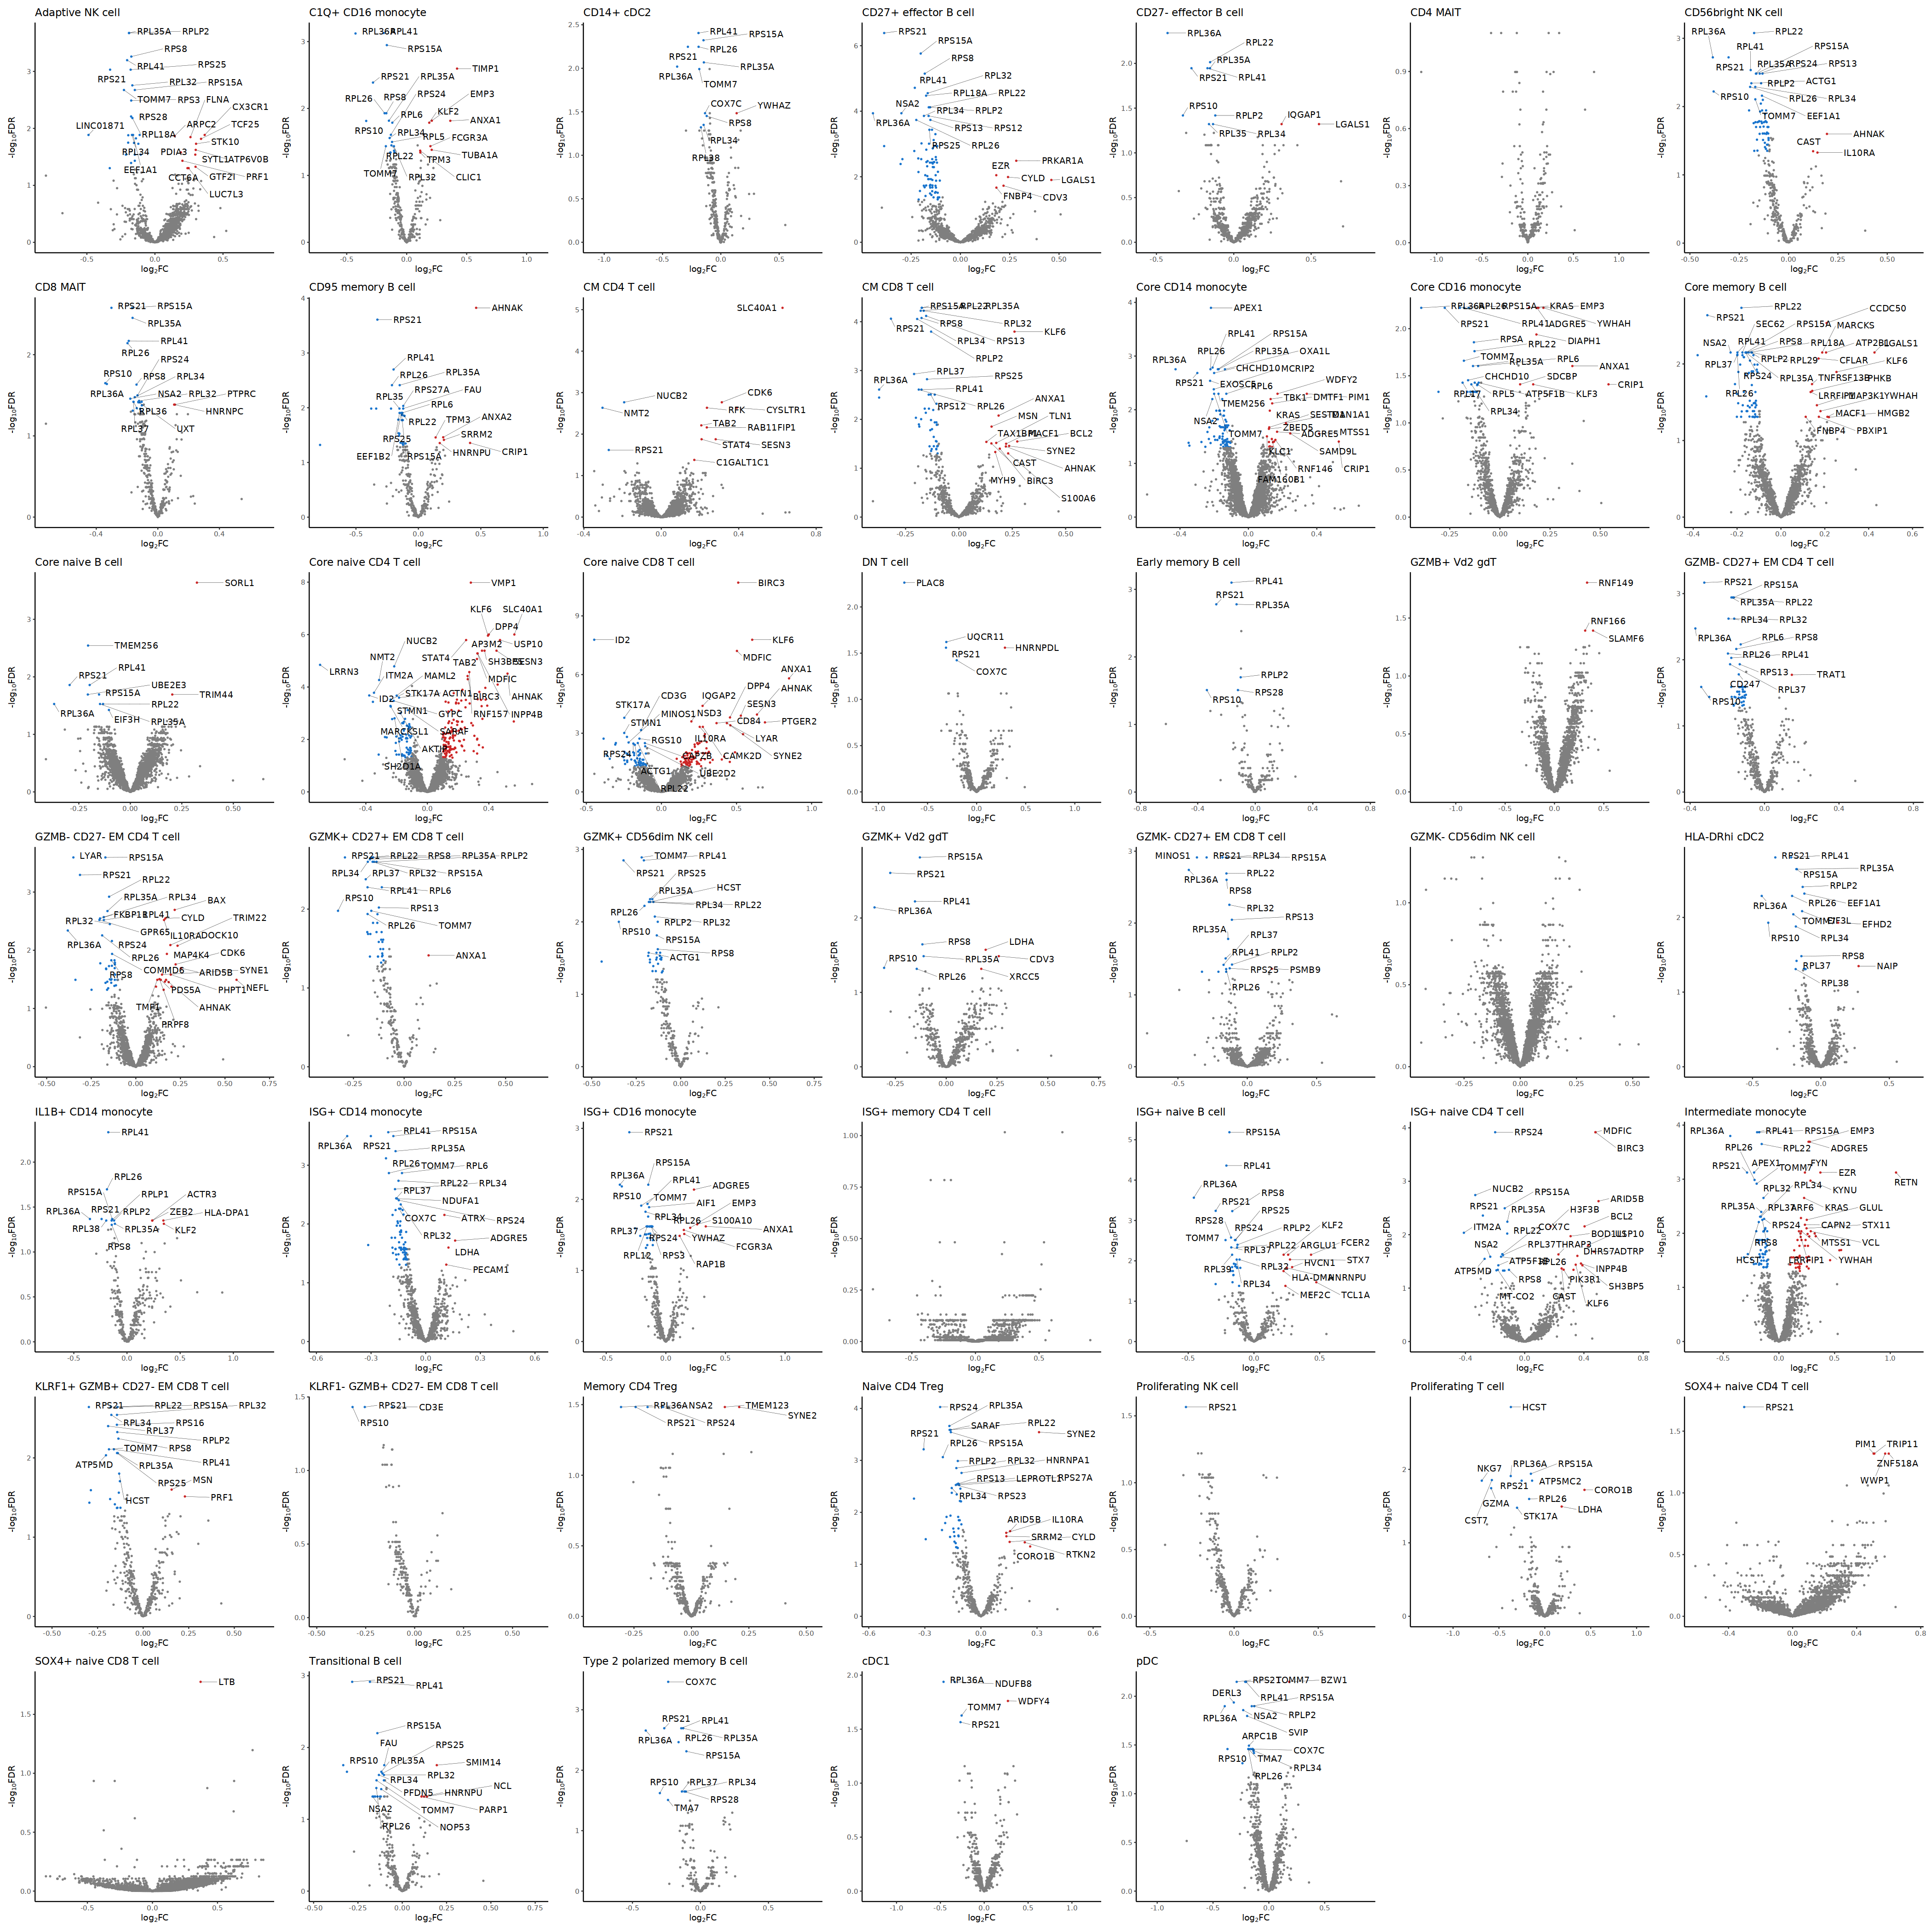

In [59]:
celltyppes_selected<-unique(freq%>% filter(ImmuneType==4) %>% select(celltype) %>% pull())
DEG_singleImmuneType<-DEG%>% filter(ImmuneType==4) %>% filter(celltype %in% celltyppes_selected)
Plot_list<-list()

for (i in 1:length(celltyppes_selected)){

data <- DEG_singleImmuneType %>% filter(celltype==celltyppes_selected[i])%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.05 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))
top <- 15
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top)
)
    
Plot_list[[i]]<-ggplot(data, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = Expression), size = 2/5) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated"="dodgerblue3", "Unchanged"="gray50", "Up-regulated"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=1.5))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=15,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(log2FoldChange, -log(padj,10), label = Gene),
                   size = 4)+ ggtitle(celltyppes_selected[i])+theme_classic()+ theme(legend.position = "none")
}
options(repr.plot.width = 35, repr.plot.height = 35)

wrap_plots(Plot_list)+ guides(colour = "colorbar",size = "none")

In [71]:
DEG_singleImmuneType_sub<-DEG_singleImmuneType %>% filter(Expression=='Up-regulated')

In [73]:
dd<-data.frame(table(DEG_singleImmuneType_sub$Gene))  %>% arrange(desc(Freq))

In [77]:
pull(head(dd,20)['Var1'])

[1] AHNAK  KLF6   ANXA1  CAST   GAPDH  EZR    HNRNPU S100A6 ADGRE5 CRIP1 
[11] FLNA   IL10RA CYLD   DIAPH1 EMP3   MACF1  MSN    NEAT1  SESN3  YWHAZ 
567 Levels: ABCD2 ABHD3 AC058791.1 ACTR2 ACTR3 ADAR ADD1 ADGRE5 ADTRP ... ZNF518A